In [29]:
import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
try:
    with open("api_key.txt", "r") as f:
        api_key = f.readline()
except FileNotFoundError:
    api_key = None
client = Socrata("data.cityofnewyork.us", api_key, timeout=10000)

In [16]:
number_per_year = """
SELECT
    date_extract_y(created_date) as year,
    count(unique_key) as entries
GROUP BY
    year
"""

npy_results = client.get("erm2-nwe9", query=number_per_year)
npy_df = pd.DataFrame.from_records(npy_results)
npy_df


,year,entries
0,2010,2089787
1,2011,2011176
2,2012,1837124
3,2013,1887594
4,2014,2156743
5,2015,2322511
6,2016,2409047
7,2017,2508523
8,2018,2760144
9,2019,2633181


<Axes: title={'center': 'NYC 311 Requests (Millions) by Year'}, xlabel='Year', ylabel='Opened Requests (Millions)'>

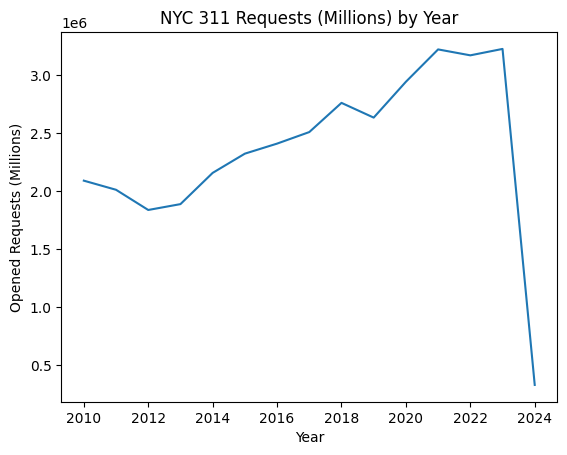

In [28]:
npy_df = npy_df.astype(int)

npy_df.plot(
    x="year", y="entries",
    kind='line', title="NYC 311 Requests (Millions) by Year",
    xlabel="Year", ylabel="Opened Requests (Millions)",
    legend=False
)
# npy_df.plot()

In [142]:
agency_name_map_q = """
SELECT DISTINCT
    agency, agency_name
WHERE agency IS NOT NULL AND agency_name IS NOT NULL
LIMIT 20000
"""
agency_name_results = client.get("erm2-nwe9", content_type="json", query=agency_name_map_q)
agname_df = pd.DataFrame.from_records(agency_name_results)
agname_df

,agency,agency_name
0,DOE,School - The Stephanie A Vierno School
1,DOE,School - John F Kennedy High School
2,DOE,School - Mark Twain IS 239 for the Gifted and ...
3,DOE,School - East Side Community High School
4,DOE,School - Far Rockaway High School
...,...,...
1884,DOE,School - PS 295
1885,DOE,School - Brownsville Collaborative Middle School
1886,DOE,School - Academy for Young Writers A
1887,DOE,School - East Side Middle School


In [157]:
from itertools import chain


agname_dict = agname_df.set_index("agency")
agname_dict = agname_dict.groupby(agname_dict.index).apply(lambda x: x.to_dict(orient="records")).to_dict()
for k, v in agname_dict.items():
    agname_dict[k] = list(chain(*[list(c.values()) for c in v]))
# agname_dict

In [177]:
agname_dict["DCA"]

['DCA', 'Department of Consumer Affairs']

In [51]:
# focus on 2017-2023
q2017 = """
SELECT
    created_date,
    closed_date,
    agency,
    complaint_type,
    descriptor,
    status,
    resolution_description,
    due_date,
    resolution_action_updated_date,
    latitude,
    longitude
WHERE
    date_extract_y(created_date)=2017 OR
    date_extract_y(closed_date)=2017
LIMIT 200000
"""

q2017_results = client.get("erm2-nwe9", content_type="json", query=q2017)
q2017_df = pd.DataFrame.from_records(q2017_results)


In [57]:
q2017_df

,created_date,closed_date,agency,complaint_type,status,resolution_action_updated_date,latitude,longitude,descriptor,resolution_description,due_date
0,2018-06-11T12:12:00.000,2017-11-27T00:00:00.000,DEP,FATF,Pending,2017-11-27T00:00:00.000,40.59009440203092,-73.93216266392051,NaN,NaN,NaN
1,2018-05-11T11:51:00.000,2017-03-10T00:00:00.000,DEP,FATF,Pending,2017-03-10T00:00:00.000,40.734382374301646,-73.8643093383117,NaN,NaN,NaN
2,2018-05-01T09:19:00.000,2017-07-19T00:00:00.000,DEP,FATF,Pending,2017-07-19T00:00:00.000,40.73460524661411,-73.86477435893579,NaN,NaN,NaN
3,2018-04-27T09:21:00.000,2017-09-21T00:00:00.000,DEP,FATF,Pending,2017-09-21T00:00:00.000,40.77842060522387,-73.89459283090625,NaN,NaN,NaN
4,2018-03-14T00:00:00.000,2017-03-15T15:30:00.000,DOHMH,Food Poisoning,Pending,2017-03-15T15:30:00.000,40.814361934485596,-73.91325666572591,3 or More,Callers should contact the DOHMH Foodborne Ill...,2018-03-28T12:47:14.000
...,...,...,...,...,...,...,...,...,...,...,...
199995,2017-12-04T08:25:56.000,2017-12-04T09:53:03.000,DHS,Homeless Person Assistance,Closed,2017-12-04T09:53:03.000,40.88270955300674,-73.88124583052429,N/A,The mobile outreach response team offered serv...,2017-12-04T11:51:57.000
199996,2017-12-04T08:25:32.000,2017-12-11T10:26:58.000,DOT,Street Condition,Closed,2017-12-11T10:26:58.000,40.66493344585147,-73.93147377784696,Plate Condition - Noisy,The Department of Transportation inspected the...,2017-12-14T08:25:32.000
199997,2017-12-04T08:25:32.000,2017-12-08T13:05:45.000,DOT,Street Sign - Dangling,Closed,2017-12-08T13:05:45.000,40.80140018861735,-73.95422219756892,"No Parking, Standing, Stopping",The Department of Transportation has completed...,2017-12-21T08:29:06.000
199998,2017-12-04T08:25:00.000,2017-12-06T12:00:00.000,DSNY,Missed Collection (All Materials),Closed,2017-12-06T12:00:00.000,40.82783032698556,-73.90631225360411,1 Missed Collection,The Department of Sanitation investigated this...,NaN


In [63]:
import pyarrow
time_feats = [
    "created_date",
    "closed_date",
    "due_date",
    "resolution_action_updated_date"
]
numeric_feats = [
    "latitude",
    "longitude"
]
for f in time_feats:
    q2017_df[f] = pd.to_datetime(q2017_df[f], format = "ISO8601")

for f in numeric_feats:
    q2017_df[f] = pd.to_numeric(q2017_df[f])

# q2017_df.convert_dtypes(dtype_backend="pyarrow")
# q2017_df.to_feather("2017_1_200k.feather")
# q2017_df.to_datetime()

In [66]:
q2017_df[q2017_df["status"]!="Closed"]

,created_date,closed_date,agency,complaint_type,status,resolution_action_updated_date,latitude,longitude,descriptor,resolution_description,due_date
0,2018-06-11 12:12:00,2017-11-27 00:00:00,DEP,FATF,Pending,2017-11-27 00:00:00,40.590094,-73.932163,NaN,NaN,NaT
1,2018-05-11 11:51:00,2017-03-10 00:00:00,DEP,FATF,Pending,2017-03-10 00:00:00,40.734382,-73.864309,NaN,NaN,NaT
2,2018-05-01 09:19:00,2017-07-19 00:00:00,DEP,FATF,Pending,2017-07-19 00:00:00,40.734605,-73.864774,NaN,NaN,NaT
3,2018-04-27 09:21:00,2017-09-21 00:00:00,DEP,FATF,Pending,2017-09-21 00:00:00,40.778421,-73.894593,NaN,NaN,NaT
4,2018-03-14 00:00:00,2017-03-15 15:30:00,DOHMH,Food Poisoning,Pending,2017-03-15 15:30:00,40.814362,-73.913257,3 or More,Callers should contact the DOHMH Foodborne Ill...,2018-03-28 12:47:14
...,...,...,...,...,...,...,...,...,...,...,...
199949,2017-12-04 08:32:00,2017-12-01 08:32:00,DOT,Street Light Condition,Pending,2017-12-01 08:32:00,NaN,NaN,Fixture/Luminaire Missing,Service Request status for this request is ava...,NaT
199950,2017-12-04 08:32:00,2017-12-01 08:32:00,DOT,Street Light Condition,Pending,2017-12-01 08:32:00,NaN,NaN,Street Light Cycling,Service Request status for this request is ava...,NaT
199957,2017-12-04 08:31:00,2017-12-01 08:31:00,DOT,Street Light Condition,Pending,2017-12-01 08:31:00,NaN,NaN,Street Light Out,Service Request status for this request is ava...,NaT
199962,2017-12-04 08:30:00,2017-12-01 08:30:00,DOT,Street Light Condition,Pending,2017-12-01 08:30:00,NaN,NaN,Street Light Cycling,Service Request status for this request is ava...,NaT


In [87]:
created_by_date_by_agency = q2017_df.groupby(by=[q2017_df["created_date"].dt.date, q2017_df["agency"]])["created_date"].count()
created_by_date_by_agency

created_date  agency
2017-12-04    ACS         2
              DCA        49
              DCAS        3
              DEP       479
              DFTA       39
                       ... 
2018-03-14    DOHMH       1
2018-04-27    DEP         1
2018-05-01    DEP         1
2018-05-11    DEP         1
2018-06-11    DEP         1
Name: created_date, Length: 516, dtype: int64

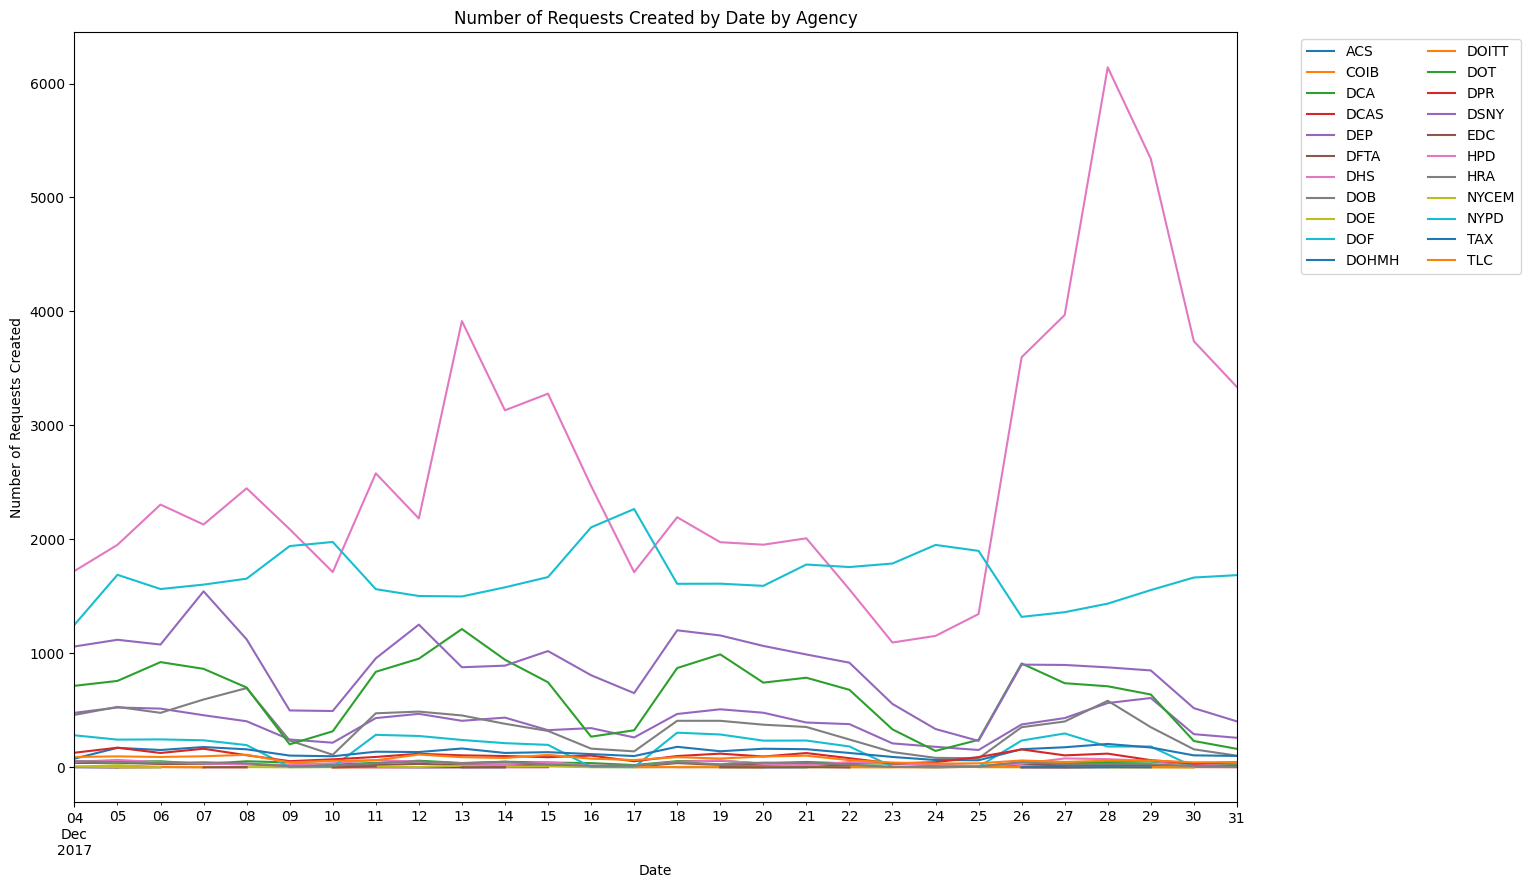

In [126]:
agency_created = created_by_date_by_agency.unstack()
# agency_created.plot()
agency_created = agency_created.set_index(pd.to_datetime(agency_created.index))
ax = agency_created[:"2018-01-01"].plot()
ax.legend(loc="upper right", ncol=2,bbox_to_anchor=[1.25,1])
ax.set_xlabel("Date")
ax.set_ylabel("Number of Requests Created")
ax.set_title("Number of Requests Created by Date by Agency")
fig = ax.get_figure()
fig.set_size_inches(15,10)

-73.9232548285547 40.73390865622287


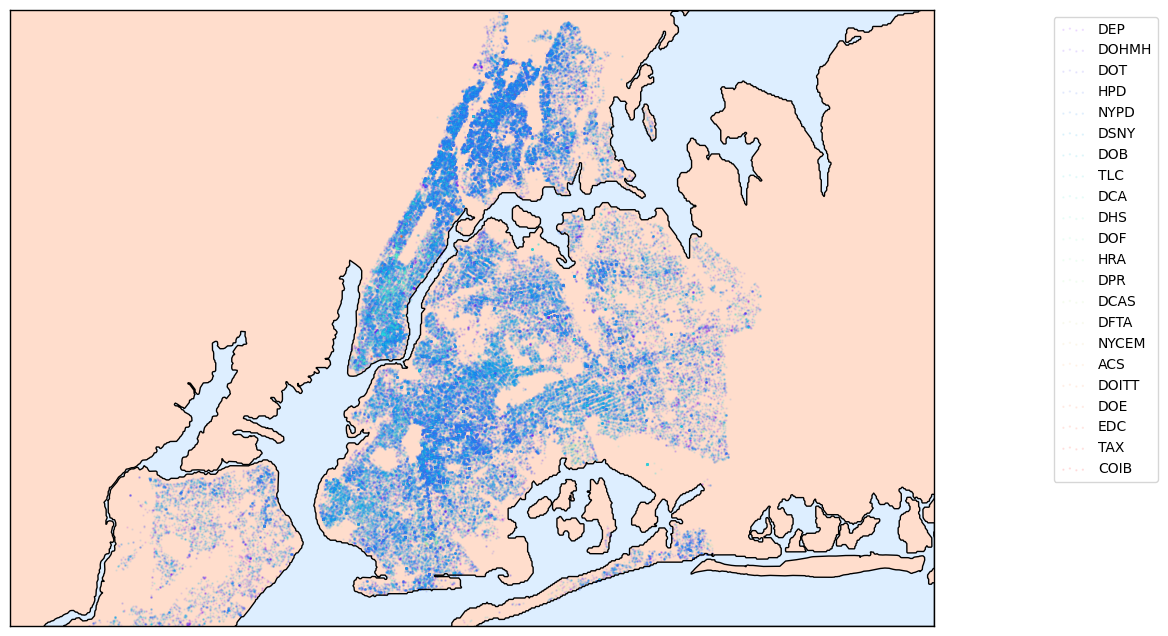

In [183]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

agency = q2017_df["agency"].unique()
# Generate unique colors for each unique value
num_unique_values = len(agency)
colors = plt.cm.rainbow(np.linspace(0, 1, num_unique_values))

# Map unique values to unique colors
color_map = dict(zip(agency, colors))

avg_lat = q2017_df["latitude"].mean()
avg_lon = q2017_df["longitude"].mean()
print(avg_lon, avg_lat)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
m = Basemap(projection='gnom', lat_0=avg_lat, lon_0=avg_lon,
                width=60_000, height=40_000, resolution="f", ax=ax)
m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()

for group, color in color_map.items():
    group_data = q2017_df[q2017_df['agency'] == group]
    m.scatter(
        group_data["longitude"], group_data["latitude"],
        latlon=True, color=color, label=group, alpha = 0.1,
        s=0.5
        # c=q2017_df["agency"]
        )
ax.legend(loc="upper right", ncol=1,bbox_to_anchor=[1.25,1], scatterpoints=4)


In [170]:
# Create Target Feature
q2017_df["time_to_complete"] = q2017_df["closed_date"] - q2017_df["created_date"]

In [74]:
per_impossible = len(q2017_df[q2017_df["time_to_complete"]<pd.Timedelta(0)])/len(q2017_df) * 100
print(f"Percentage of negative completion times: {per_impossible:.3f}%")

Percentage of negative completion times: 0.646%


In [171]:
q2017_df['days_to_complete'] = q2017_df['time_to_complete'].dt.total_seconds()//(24*3600)


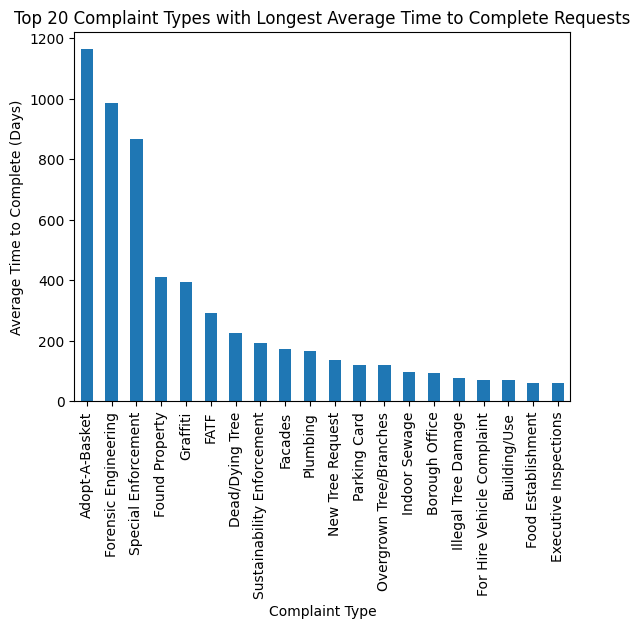

In [172]:

# mean time to complete requests for each complaint type
mean_time_by_type = q2017_df.groupby("complaint_type")["days_to_complete"].mean()

# top 20 complaint types with the longest average time to complete requests
sorted_mean_time_by_type = mean_time_by_type.sort_values(ascending=False)
top_20_types = sorted_mean_time_by_type.head(20)

# plot them
top_20_types.plot.bar()

plt.title('Top 20 Complaint Types with Longest Average Time to Complete Requests')
plt.xlabel('Complaint Type')
plt.ylabel('Average Time to Complete (Days)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.show()

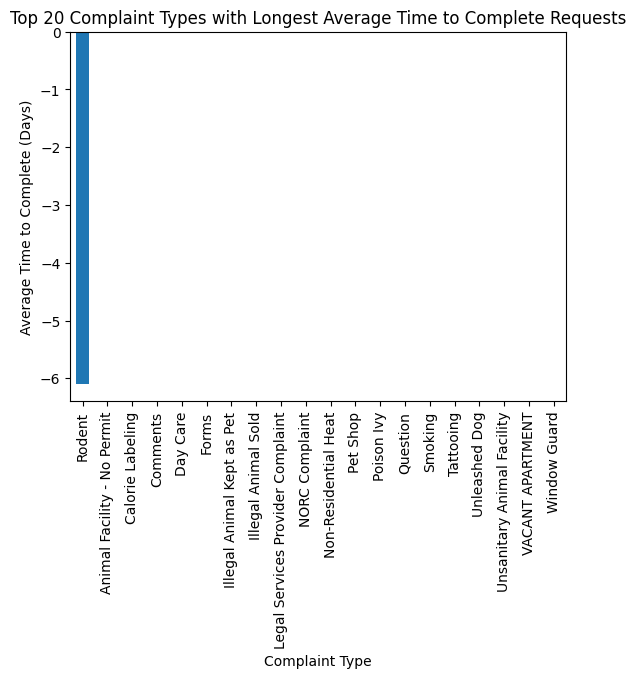

In [173]:
bottom_20 = sorted_mean_time_by_type.tail(20)
# plot them
bottom_20.plot.bar()

plt.title('Top 20 Complaint Types with Longest Average Time to Complete Requests')
plt.xlabel('Complaint Type')
plt.ylabel('Average Time to Complete (Days)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.show()

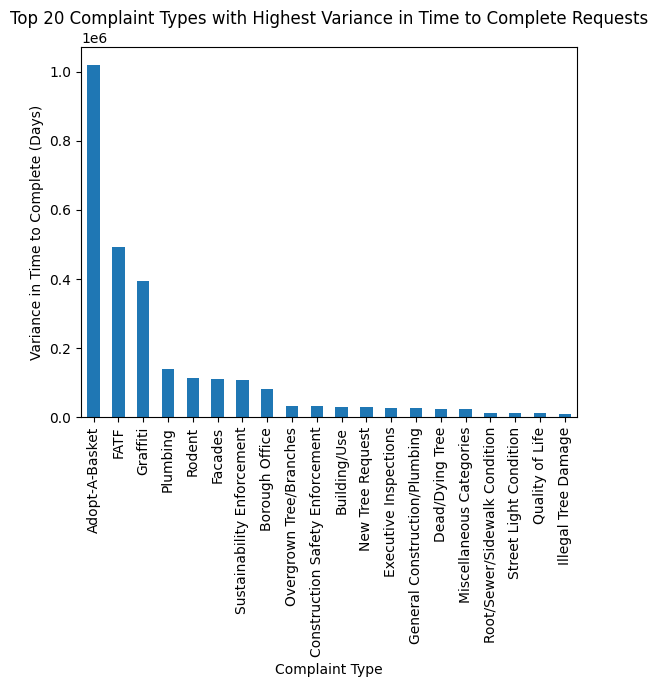

In [185]:
# variance in time to complete requests for each complaint type
var_time_by_type = q2017_df.groupby("complaint_type")["days_to_complete"].var()

# top 20 complaint types with the longest variance in time to complete requests
sorted_var_time_by_type = var_time_by_type.sort_values(ascending=False)
top_20_var = sorted_var_time_by_type.head(20)

# plot them
top_20_var.plot.bar()

plt.title('Top 20 Complaint Types with Highest Variance in Time to Complete Requests')
plt.xlabel('Complaint Type')
plt.ylabel('Variance in Time to Complete (Days)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.show()

In [65]:
q2017_df["status"].unique()


array(['Pending', 'Closed', 'Open', 'Assigned', 'Email Sent', 'Started'],
      dtype=object)

In [32]:
q2017_df["agency"].unique()

array(['DEP', 'DOHMH', 'DOT', 'HPD', 'NYPD', 'DSNY', 'DOB', 'TLC', 'DCA',
       'DHS', 'DOF', 'HRA', 'DPR', 'DCAS', 'DFTA', 'NYCEM', 'ACS',
       'DOITT', 'DOE', 'EDC'], dtype=object)

In [34]:
q2017_df["complaint_type"].unique()


array(['FATF', 'Food Poisoning', 'Street Light Condition',
       'Traffic Signal Condition', 'HEAT/HOT WATER',
       'Noise - Residential', 'Illegal Parking',
       'Noise - Street/Sidewalk', 'WATER LEAK', 'Blocked Driveway',
       'DOOR/WINDOW', 'ELECTRIC', 'Noise - Commercial',
       'Request Large Bulky Item Collection', 'Water System', 'Plumbing',
       'PLUMBING', 'For Hire Vehicle Report', 'Noise - Vehicle', 'Noise',
       'Animal Abuse', 'Non-Residential Heat', 'Drug Activity',
       'PAINT/PLASTER', 'UNSANITARY CONDITION', 'GENERAL',
       'Consumer Complaint', 'For Hire Vehicle Complaint',
       'Taxi Complaint', 'Sewer', 'Smoking', 'Lead', 'Elevator', 'SAFETY',
       'Street Condition', 'General Construction/Plumbing',
       'Sanitation Condition', 'Missed Collection (All Materials)',
       'Homeless Encampment', 'FLOORING/STAIRS',
       'Homeless Person Assistance', 'Electronics Waste',
       'Noise - House of Worship', 'Snow', 'APPLIANCE',
       'Water Conse

In [35]:
len(q2017_df["descriptor"].unique())


479